In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show, show_hist

In [6]:
#load the excel data
df = pd.read_excel('field_observation.xls')
point_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y))
point_data.set_crs(epsg=32644, inplace=True)
point_data.to_file('point_data.shp')

In [7]:
!gdal_translate np_20011024_refl.img -b 4 -b 5 -b 3 np_20011024_refl.tif

Input file size is 400, 834
0...10...20...30...40...50...60...70...80...90...100 - done.


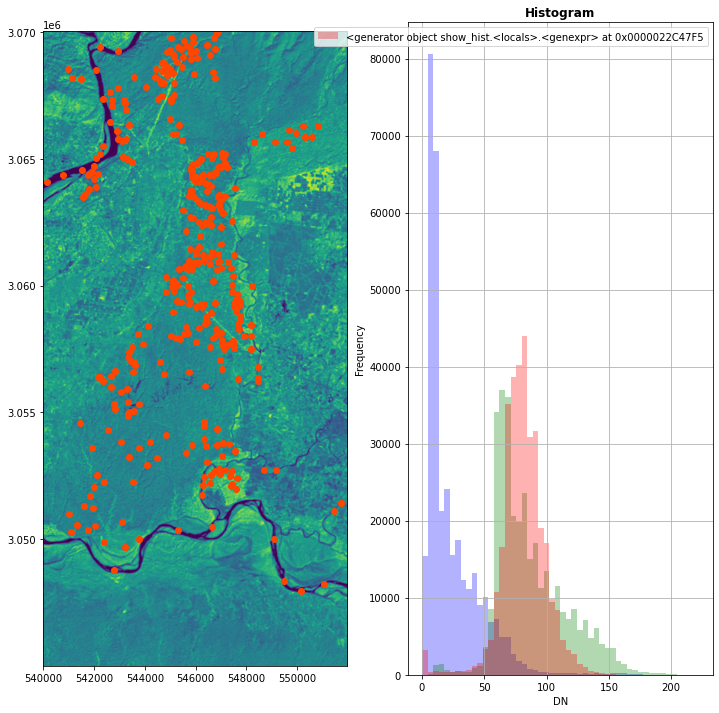

In [8]:
s = rasterio.open('np_20011024_refl.tif')
fig, (ax, axhist) = plt.subplots(1, 2, figsize=(12,12))
point_data.plot(ax=ax, color='orangered')
show(s, ax=ax)
show_hist(s, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

In [9]:
coords = [(x,y) for x, y in zip(point_data.X, point_data.Y)]
point_data['Raster Value'] = [x for x in s.sample(coords)]

In [10]:
point_data

,Plot,X,Y,nnx,nny,canopy density (%),light intensity,geometry,Raster Value
0,0,548171,3057513,273.033333,416.966667,0.0,18.40,POINT (548171.000 3057513.000),"[145, 152, 38]"
1,1,547415,3052674,247.833333,578.266667,81.0,2.20,POINT (547415.000 3052674.000),"[128, 90, 3]"
2,2,547177,3052725,239.900000,576.566667,46.0,11.80,POINT (547177.000 3052725.000),"[93, 76, 5]"
3,3,546887,3052673,230.233333,578.300000,84.8,1.90,POINT (546887.000 3052673.000),"[132, 88, 8]"
4,4,546619,3052552,221.300000,582.333333,79.0,2.30,POINT (546619.000 3052552.000),"[117, 82, 8]"
...,...,...,...,...,...,...,...,...,...
367,367,549780,3065424,326.666667,153.266667,76.0,4.27,POINT (549780.000 3065424.000),"[86, 76, 7]"
368,368,550326,3065855,344.866667,138.900000,81.0,1.60,POINT (550326.000 3065855.000),"[117, 91, 9]"
369,369,549604,3065668,320.800000,145.133333,81.0,3.60,POINT (549604.000 3065668.000),"[91, 72, 4]"
370,370,548628,3065963,288.266667,135.300000,75.1,2.87,POINT (548628.000 3065963.000),"[77, 82, 61]"
